# Downloading, pre-processing and running cNMF on Zepp et. al 2021 data
1. Obtaining the AnnData object and complementary metadata
2. filtering genes, and showing key statistics
3. Subsetting and splitting the dataset by developmental stage, and selecting joint highly variable genes (HVG)
4. Running consensus NMF (cNMF) per stage
5. Selecting parameters for the cNMF
6. Running the comparator for adjacent steps



In [1]:
%%time
%load_ext autoreload
%autoreload 2

#debug:
from importlib import reload

import sys
import os
import time

import numpy as np
import pandas as pd
from scipy import sparse
from sklearn.metrics import silhouette_samples
import scanpy as sc
import matplotlib.pyplot as plt

from gepdynamics import _utils
from gepdynamics import _constants
from gepdynamics import cnmf
from gepdynamics import comparator

_utils.cd_proj_home()
print(os.getcwd())


/cs/labs/mornitzan/yotamcon/gep-dynamics
CPU times: user 2.52 s, sys: 1.45 s, total: 3.98 s
Wall time: 1min 17s


## 1. Obtaining the AnnData object and complementary metadata
The adata contains log1p(CP10K) data, we un-transform the data to have the original counts as `X`

In [2]:
results_dir = _utils.set_dir('results')
results_dir = _utils.set_dir(results_dir.joinpath('zepp'))
data_dir = _utils.set_dir('data')
GSE_dir = _utils.set_dir(data_dir.joinpath('GSE149563'))

In [4]:
%%script --no-raise-error false # remove this to run the downloading

# Adata downloaded from https://data-browser.lungmap.net/explore/projects/00f056f2-73ff-43ac-97ff-69ca10e38c89/get-curl-command
# by running this for the adata: 
!(cd {GSE_dir.as_posix()} && curl --location --fail 'https://service.azul.data.humancellatlas.org/manifest/files?catalog=lm3&format=curl&filters=%7B%22fileFormat%22%3A+%7B%22is%22%3A+%5B%22h5ad%22%5D%7D%2C+%22projectId%22%3A+%7B%22is%22%3A+%5B%2200f056f2-73ff-43ac-97ff-69ca10e38c89%22%5D%7D%2C+%22genusSpecies%22%3A+%7B%22is%22%3A+%5B%22Mus+musculus%22%5D%7D%7D&objectKey=manifests%2Fe42d976a-5137-5422-be32-39008e1d53d7.1ad7b2a4-0d0f-55d3-9d0c-6c37e8d46dc8.curlrc' | curl --config - )
# and then running this for the metadata: 
!(cd {GSE_dir.as_posix()} && curl --location --fail 'https://service.azul.data.humancellatlas.org/manifest/files?catalog=lm3&format=curl&filters=%7B%22fileFormat%22%3A+%7B%22is%22%3A+%5B%22csv%22%5D%7D%2C+%22projectId%22%3A+%7B%22is%22%3A+%5B%2200f056f2-73ff-43ac-97ff-69ca10e38c89%22%5D%7D%2C+%22genusSpecies%22%3A+%7B%22is%22%3A+%5B%22Mus+musculus%22%5D%7D%7D&objectKey=manifests%2Fed538a08-689b-530d-a661-e1756132b883.1ad7b2a4-0d0f-55d3-9d0c-6c37e8d46dc8.curlrc' | curl --config -)

download_dir = GSE_dir.joinpath('a078a6cb-a72a-305c-80df-cf35aedd01ff')
! mv {download_dir.as_posix()}/* {GSE_dir.as_posix()}
! rmdir {download_dir.as_posix()}

In [12]:
%%time

%time adata = sc.read(GSE_dir.joinpath('JZ_Mouse_TimeSeries.h5ad'))
metadata = pd.read_csv(GSE_dir.joinpath('AllTimePoints_metadata.csv'), index_col=0)

adata.obs['celltype'] = metadata.var_celltype
adata.obs['compartment'] = metadata.var_compartment

untransformed = sparse.csr_matrix(adata.obs.n_molecules.values[:, None].astype(np.float32) / 10_000).multiply(adata.X.expm1())
adata.X = sparse.csc_matrix(untransformed).rint()

del untransformed

adata

CPU times: user 4.62 s, sys: 358 ms, total: 4.97 s
Wall time: 11.8 s
CPU times: user 8.37 s, sys: 836 ms, total: 9.21 s
Wall time: 16 s


AnnData object with n_obs × n_vars = 67794 × 18129
    obs: 'development_stage', 'n_molecules', 'n_genes', 'percent.mito', 'S.Score', 'G2M.Score', 'Phase', 'var_time', 'cell_type', 'CellID', 'cell_names', 'celltype', 'compartment'
    var: 'name'
    obsm: 'X_pca', 'X_tsne', 'X_umap'

In [13]:
adata.obs.development_stage = adata.obs.development_stage.cat.rename_categories(
    {'Adult': 'P42', 'E12.5': 'E12', 'E15.5': 'E15', 'E17.5': 'E17'}).cat.reorder_categories(
    ['E12', 'E15', 'E17', 'P3', 'P7', 'P15', 'P42'])

/cs/labs/mornitzan/yotamcon/miniconda3/envs/pp_t/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/cs/labs/mornitzan/yotamcon/miniconda3/envs/pp_t/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


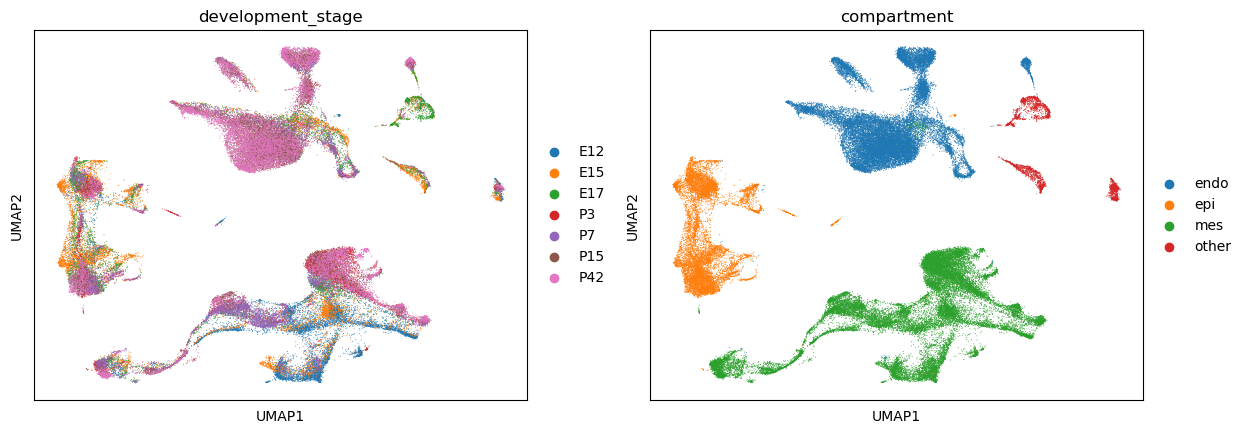

/cs/labs/mornitzan/yotamcon/miniconda3/envs/pp_t/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


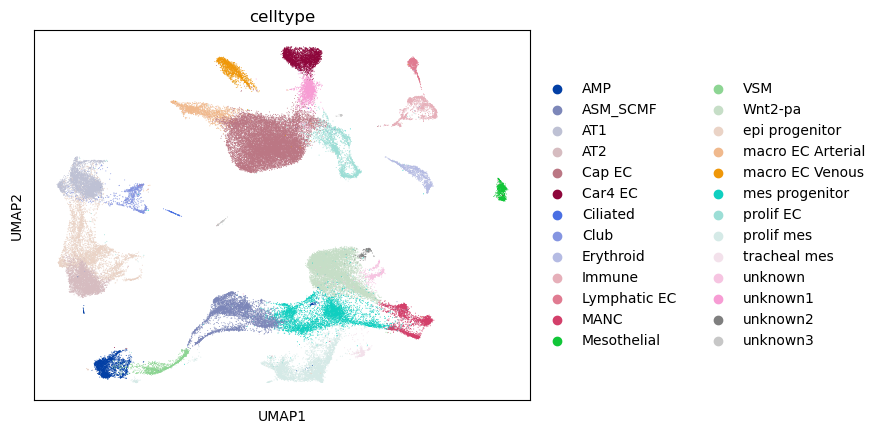

In [14]:
sc.pl.umap(adata, color=['development_stage', 'compartment'])
sc.pl.umap(adata, color=['celltype'])

adata.uns['development_stage_colors_dict'] = dict(zip(adata.obs['development_stage'].cat.categories, adata.uns['development_stage_colors']))
adata.uns['compartment_colors_dict'] = dict(zip(adata.obs['compartment'].cat.categories, adata.uns['compartment_colors']))
adata.uns['celltype_colors_dict'] = dict(zip(adata.obs['celltype'].cat.categories, adata.uns['celltype_colors']))

In [15]:
pd.crosstab(adata.obs.development_stage, adata.obs.compartment)

compartment,endo,epi,mes,other
development_stage,,,,
E12,133,679,7752,403
E15,1095,3676,2516,1017
E17,1681,2573,2012,937
P3,2991,2196,5063,141
P7,3992,1632,4433,140
P15,7345,739,2327,108
P42,7646,1041,3404,122


In [16]:
pd.crosstab(adata.obs.celltype, adata.obs.development_stage)

development_stage,E12,E15,E17,P3,P7,P15,P42
celltype,,,,,,,
AMP,178,224,317,327,356,189,376
ASM_SCMF,732,227,417,678,1936,378,263
AT1,125,711,779,865,344,248,355
AT2,54,243,739,815,811,432,517
Cap EC,55,557,783,1517,2073,5239,4875
Car4 EC,0,0,30,346,430,908,1078
Ciliated,0,0,5,61,5,2,4
Club,112,418,157,94,72,26,54
Erythroid,53,601,114,18,70,65,7


In [17]:
pd.crosstab(adata.obs.celltype, adata.obs.compartment)

compartment,endo,epi,mes,other
celltype,,,,
AMP,0,0,1967,0
ASM_SCMF,0,0,4631,0
AT1,0,3427,0,0
AT2,0,3611,0,0
Cap EC,15099,0,0,0
Car4 EC,2792,0,0,0
Ciliated,0,77,0,0
Club,0,933,0,0
Erythroid,0,0,0,928


## 2. filtering genes, selecting joint highly variable genes (HVGs) and showing key statistics


In [18]:
%%time
print(f'before filtering shape was {adata.X.shape}')

# filtering genes with very low abundance
sc.pp.filter_genes(adata, min_cells=np.round(adata.shape[0] / 1000))

# getting general statistics for counts abundance
sc.pp.filter_genes(adata, min_counts=0)
sc.pp.filter_cells(adata, min_counts=0)
sc.pp.filter_cells(adata, min_genes=0)

sc.pp.highly_variable_genes(adata, flavor='seurat_v3', n_top_genes=_constants.NUMBER_HVG)

print(f'after filtering shape is {adata.X.shape}')

adata

before filtering shape was (67794, 18129)
after filtering shape is (67794, 16184)
CPU times: user 7.12 s, sys: 1.83 s, total: 8.95 s
Wall time: 10.8 s


AnnData object with n_obs × n_vars = 67794 × 16184
    obs: 'development_stage', 'n_molecules', 'n_genes', 'percent.mito', 'S.Score', 'G2M.Score', 'Phase', 'var_time', 'cell_type', 'CellID', 'cell_names', 'celltype', 'compartment', 'n_counts'
    var: 'name', 'n_cells', 'n_counts', 'highly_variable', 'highly_variable_rank', 'means', 'variances', 'variances_norm'
    uns: 'development_stage_colors', 'compartment_colors', 'celltype_colors', 'development_stage_colors_dict', 'compartment_colors_dict', 'celltype_colors_dict', 'hvg'
    obsm: 'X_pca', 'X_tsne', 'X_umap'

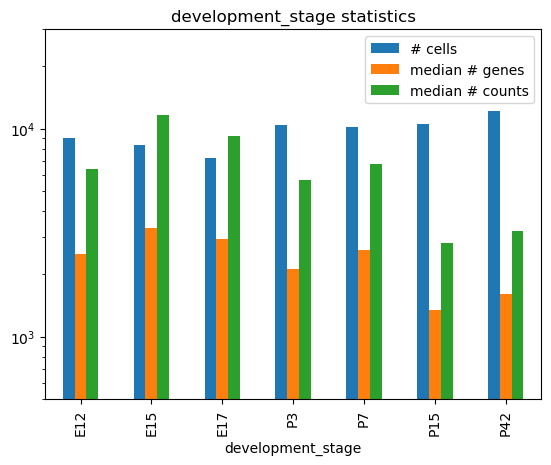

In [20]:
column_of_interest = 'development_stage'

stats_df = adata.obs.loc[:, [column_of_interest, 'n_genes', 'n_counts']].groupby(
    [column_of_interest]).median()

stats_df = pd.concat([adata.obs.groupby([column_of_interest]).count().iloc[:, 0],
                      stats_df], axis=1)
stats_df.columns = ['# cells', 'median # genes', 'median # counts']

stats_df.plot(kind='bar', title=f'{column_of_interest} statistics', log=True, ylim=((5e2, 3e4)))
plt.show()
del column_of_interest, stats_df

In [21]:
_utils.joint_hvg_across_stages(adata, obs_category_key='development_stage', n_top_genes=5000)
adata.var

,name,n_cells,n_counts,highly_variable,highly_variable_rank,means,variances,variances_norm,development_stage_max_var_norm,joint_highly_variable
Sox17,Sox17,18167,41543.0,True,954.0,0.612783,2.185803,1.911305,6.756488,True
Mrpl15,Mrpl15,22890,36466.0,False,NaN,0.537894,0.938963,0.989088,0.989088,False
Lypla1,Lypla1,18216,23039.0,False,NaN,0.339838,0.400800,0.778880,0.927863,False
Tcea1,Tcea1,29410,45005.0,False,NaN,0.663849,0.906531,0.705129,0.918159,False
Atp6v1h,Atp6v1h,13201,15381.0,False,NaN,0.226878,0.249574,0.790966,0.928798,False
...,...,...,...,...,...,...,...,...,...,...
Gm12185,Gm12185,159,160.0,False,NaN,0.002360,0.002384,0.855554,0.904272,False
Olfr56,Olfr56,227,237.0,False,NaN,0.003496,0.003808,0.879820,0.970031,False
Slc22a12,Slc22a12,68,70.0,False,NaN,0.001033,0.001090,1.022095,1.022095,False
Ido1,Ido1,80,81.0,False,NaN,0.001195,0.001223,0.964506,0.964506,False


### Saving/loading the pre-processed object

In [55]:
%%time
pre_processed_adata_file = results_dir.joinpath('full.h5ad')

if not pre_processed_adata_file.exists():
    adata.write(pre_processed_adata_file)
else:
    adata = sc.read(pre_processed_adata_file)
adata

CPU times: user 254 ms, sys: 569 ms, total: 823 ms
Wall time: 14.8 s


AnnData object with n_obs × n_vars = 67794 × 16184
    obs: 'development_stage', 'n_molecules', 'n_genes', 'percent.mito', 'S.Score', 'G2M.Score', 'Phase', 'var_time', 'cell_type', 'CellID', 'cell_names', 'celltype', 'compartment', 'n_counts'
    var: 'name', 'n_cells', 'n_counts', 'highly_variable', 'highly_variable_rank', 'means', 'variances', 'variances_norm', 'development_stage_max_var_norm', 'joint_highly_variable'
    uns: 'celltype_colors', 'celltype_colors_dict', 'compartment_colors', 'compartment_colors_dict', 'development_stage_colors', 'development_stage_colors_dict', 'hvg'
    obsm: 'X_pca', 'X_tsne', 'X_umap'

## 3. Subsetting and splitting the dataset by stage, and selecting joint highly variable genes (HVG)


### Splitting the adata by "development_stage", retaining only epithelial cells and creating a normalized variance layer

/cs/labs/mornitzan/yotamcon/miniconda3/envs/pp_t/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/cs/labs/mornitzan/yotamcon/miniconda3/envs/pp_t/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


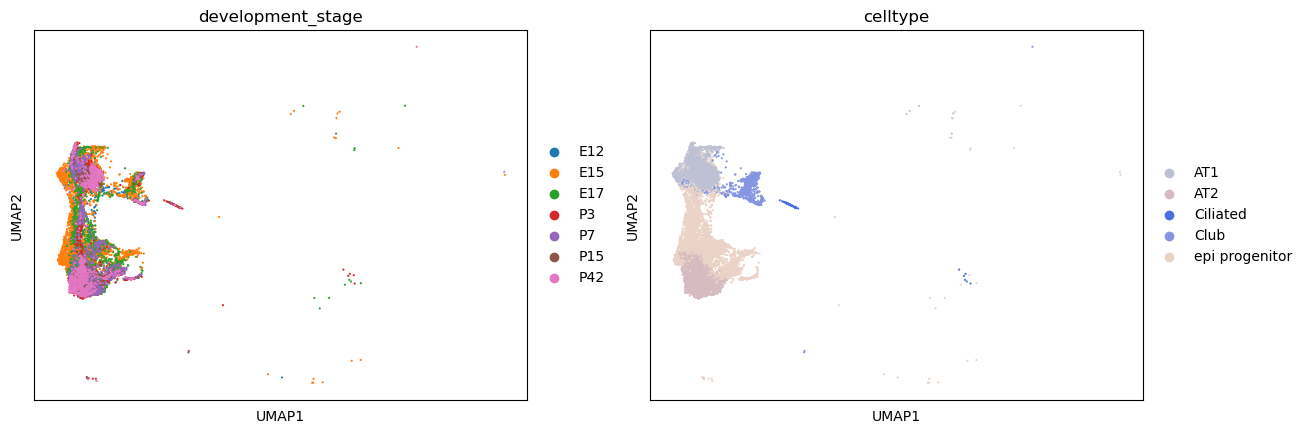

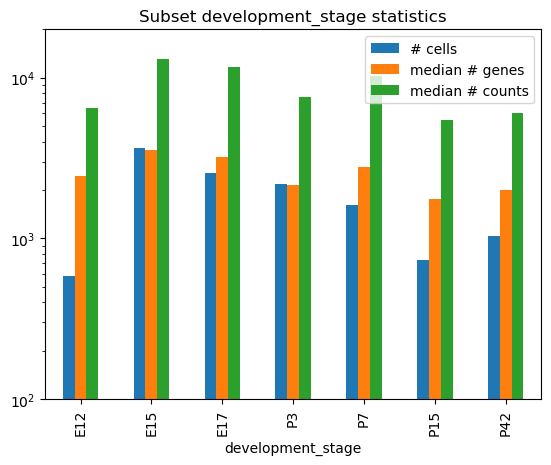

CPU times: user 7.13 s, sys: 806 ms, total: 7.94 s
Wall time: 7.62 s


AnnData object with n_obs × n_vars = 12399 × 16179
    obs: 'development_stage', 'n_molecules', 'n_genes', 'percent.mito', 'S.Score', 'G2M.Score', 'Phase', 'var_time', 'cell_type', 'CellID', 'cell_names', 'celltype', 'compartment', 'n_counts'
    var: 'name', 'n_cells', 'n_counts', 'highly_variable', 'highly_variable_rank', 'means', 'variances', 'variances_norm', 'development_stage_max_var_norm', 'joint_highly_variable'
    uns: 'celltype_colors', 'celltype_colors_dict', 'compartment_colors', 'compartment_colors_dict', 'development_stage_colors', 'development_stage_colors_dict', 'hvg'
    obsm: 'X_pca', 'X_tsne', 'X_umap'

In [110]:
%%time

column_of_interest = 'development_stage'

subset_adata_file = results_dir.joinpath('subset.h5ad')
if not subset_adata_file.exists():
    subset = adata[(adata.obs.compartment == 'epi') & (adata.obs.celltype != 'unknown3')].copy()

    sc.pp.filter_genes(subset, min_cells=1)
    sc.pp.filter_genes(subset, min_counts=1)

    _utils.joint_hvg_across_stages(subset, obs_category_key=column_of_interest, n_top_genes=5000)

    subset.write(subset_adata_file)
else:
    subset = sc.read(subset_adata_file)

# umap by celltype:
sc.pl.umap(subset, color=[column_of_interest, 'celltype'])

# statistics
stats_df = subset.obs.loc[:, [column_of_interest, 'n_genes', 'n_counts']].groupby(
    [column_of_interest]).median()

stats_df = pd.concat([subset.obs.groupby([column_of_interest]).count().iloc[:, 0],
                      stats_df], axis=1)
stats_df.columns = ['# cells', 'median # genes', 'median # counts']

stats_df.plot(kind='bar', title=f'Subset {column_of_interest} statistics', log=True, ylim=((1e2, 2e4)))
plt.show()
del stats_df

subset

In [111]:
%%time

categories = subset.obs[column_of_interest].cat.categories

split_adatas_dir = _utils.set_dir(results_dir.joinpath(f'split_{column_of_interest}'))

for cat in categories:
    print(f'working on {cat}')
    if not split_adatas_dir.joinpath(f'{cat}.h5ad').exists():
        tmp = subset[subset.obs[column_of_interest] == cat].copy()

        tmp.uns['name'] = f'{cat}'   # full name
        tmp.uns['sname'] = f'{cat[:3]}'  # short name, here it is the same

        # correcting the gene counts
        sc.pp.filter_genes(tmp, min_cells=0)
        sc.pp.filter_genes(tmp, min_counts=0)

        tmp.write_h5ad(split_adatas_dir.joinpath(f'{cat}.h5ad'))

        del tmp

working on E12
working on E15
working on E17
working on P3
working on P7
working on P15
working on P42
CPU times: user 1.36 s, sys: 211 ms, total: 1.57 s
Wall time: 5.26 s


### Running multiple NMF iterations

In [112]:
cnmf_dir = _utils.set_dir(results_dir.joinpath('cnmf'))

Directory "results/zepp/cnmf" does not exist.
trying to create it at /cs/labs/mornitzan/yotamcon/gep-dynamics/results/zepp/cnmf


In [113]:
%%time

ks = [2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14]#, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30]

for cat in categories:
    print(f'Starting on {cat}, time is {time.strftime("%H:%M:%S", time.localtime())}')
    tmp = sc.read_h5ad(split_adatas_dir.joinpath(f'{cat}.h5ad'))
    
    c_object = cnmf.cNMF(cnmf_dir, cat)
    
    # Variance normalized version of the data
    X = sc.pp.scale(tmp.X[:, tmp.var.joint_highly_variable].toarray().astype(np.float32), zero_center=False)
    
    c_object.prepare(X, ks, n_iter=100, new_nmf_kwargs={'tol': _constants.NMF_TOLERANCE,
                                                        'beta_loss': 'kullback-leibler'})
    
    c_object.factorize(0, 1, gpu=True)
    
    c_object.combine()
    
    del tmp, X

Starting on E12, time is 11:39:10
Combining factorizations for k=2.
Combining factorizations for k=3.
Combining factorizations for k=4.
Combining factorizations for k=5.
Combining factorizations for k=6.
Combining factorizations for k=7.
Combining factorizations for k=8.
Combining factorizations for k=9.
Combining factorizations for k=10.
Combining factorizations for k=11.
Combining factorizations for k=12.
Combining factorizations for k=13.
Combining factorizations for k=14.
Starting on E15, time is 11:43:12
Combining factorizations for k=4.
Combining factorizations for k=5.
Combining factorizations for k=6.
Combining factorizations for k=7.
Combining factorizations for k=8.
Combining factorizations for k=9.
Combining factorizations for k=10.
Combining factorizations for k=11.
Combining factorizations for k=12.
Combining factorizations for k=13.
Combining factorizations for k=14.
Starting on P3, time is 12:00:00
Combining factorizations for k=2.
Combining factorizations for k=3.
Combi

In [114]:
%%time
for cat in categories:
    print(f'Starting on {cat}, time is {time.strftime("%H:%M:%S", time.localtime())}')
    c_object = cnmf.cNMF(cnmf_dir, cat)
    for thresh in [0.5, 0.4]:
        print(f'working on threshold {thresh}')
        c_object.k_selection_plot(density_threshold=thresh, nmf_refitting_iters=1000,
                                  close_fig=True, show_clustering=True, gpu=True)

Starting on E12, time is 13:21:57
working on threshold 0.5
working on threshold 0.4
Starting on E15, time is 13:22:52
working on threshold 0.5
working on threshold 0.4
Starting on E17, time is 13:24:02
working on threshold 0.5
working on threshold 0.4
Starting on P3, time is 13:25:09
working on threshold 0.5
working on threshold 0.4
Starting on P7, time is 13:26:16
working on threshold 0.5
working on threshold 0.4
Starting on P15, time is 13:27:16
working on threshold 0.5
working on threshold 0.4
Starting on P42, time is 13:28:07
working on threshold 0.5
working on threshold 0.4
CPU times: user 17min 22s, sys: 30min 19s, total: 47min 42s
Wall time: 7min 3s


### Selecting the decomposition rank utilizing K-selection plots and PCA variance explained

In [92]:
%%time
df_var = pd.DataFrame()
df_cumulative_var = pd.DataFrame()

n_components = 50

for cat in categories:
    
    %time tmp = sc.read_h5ad(split_adatas_dir.joinpath(f'{cat}.h5ad'))
    
    a, b, c, d, = sc.tl.pca(tmp.X[:, tmp.var.joint_highly_variable], n_comps=n_components, return_info=True)

    df_var[f'{cat}'] = c*100
    df_cumulative_var[f'{cat}'] = c.cumsum()*100

CPU times: user 67.2 ms, sys: 3.08 ms, total: 70.3 ms
Wall time: 218 ms
CPU times: user 226 ms, sys: 709 ms, total: 936 ms
Wall time: 1.12 s
CPU times: user 180 ms, sys: 644 ms, total: 825 ms
Wall time: 749 ms
CPU times: user 183 ms, sys: 663 ms, total: 846 ms
Wall time: 511 ms
CPU times: user 182 ms, sys: 675 ms, total: 857 ms
Wall time: 453 ms
CPU times: user 181 ms, sys: 675 ms, total: 856 ms
Wall time: 197 ms
CPU times: user 190 ms, sys: 692 ms, total: 881 ms
Wall time: 254 ms
CPU times: user 6.79 s, sys: 19.4 s, total: 26.2 s
Wall time: 5.75 s


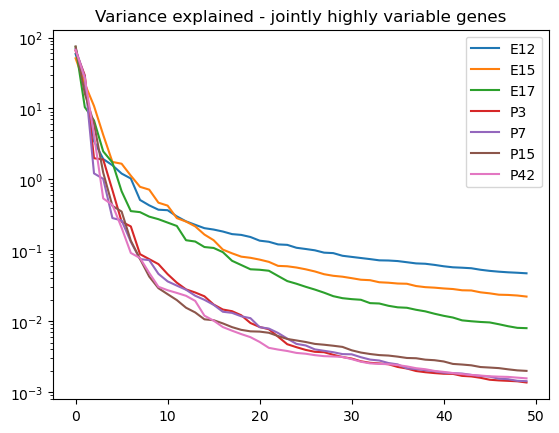

In [97]:
plt.plot(range(len(df_var)), df_var, label=df_var.columns)
plt.title('Variance explained - jointly highly variable genes')
plt.legend()
plt.yscale('log')
plt.show()

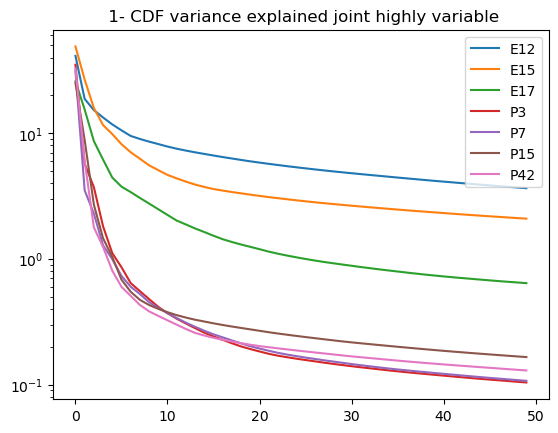

In [94]:
plt.plot(df_cumulative_var.index, 100-df_cumulative_var, label=df_var.columns)
plt.yscale('log')
plt.title(f' 1- CDF variance explained joint highly variable')
plt.legend()
plt.show()

In [117]:
%%time

selected_cnmf_params = {
    'E12': (4, 0.5),  # 
    'E15': (5, 0.5),  # 
    'E17': (8, 0.5),   # 
    'P3': (6, 0.5),    # 
    'P7': (6, 0.5),   # 
    'P15': (4, 0.5),  # 
    'P42': (5, 0.5)}   # 

split_adatas = {}

for cat, (k, threshold) in selected_cnmf_params.items():
    print(f'Working on epi {cat} with k={k} and threshold={threshold}')
    %time tmp = sc.read_h5ad(split_adatas_dir.joinpath(f'{cat}.h5ad'))

    tmp.var.joint_highly_variable = subset.var.joint_highly_variable
    
    c_object = cnmf.cNMF(cnmf_dir, cat)
    c_object.consensus(k, density_threshold=threshold, gpu=True, verbose=True,
                       nmf_refitting_iters=1000, show_clustering=False)

    usages, spectra = c_object.get_consensus_usages_spectra(k, density_threshold=threshold)

    tmp.uns['cnmf_params'] = {'k_nmf': k, 'threshold': threshold}

    tmp.obsm['usages'] = usages.copy()

    usages_norm = usages / np.sum(usages, axis=1, keepdims=True)
    tmp.obsm['usages_norm'] = usages_norm

    # get per gene z-score of data after TPM normalization and log1p transformation 
    tpm_log1p_zscore = tmp.X.toarray()
    tpm_log1p_zscore /= 1e-6 * np.sum(tpm_log1p_zscore, axis=1, keepdims=True)
    tpm_log1p_zscore = np.log1p(tpm_log1p_zscore)
    tpm_log1p_zscore = sc.pp.scale(tpm_log1p_zscore)

    usage_coefs = _utils.fastols(usages_norm, tpm_log1p_zscore)

    tmp.varm['usage_coefs'] = pd.DataFrame(
        usage_coefs.T, index=tmp.var.index,
        columns=[f'{tmp.uns["sname"]}.p{prog}' for prog in range(usages.shape[1])])
    
    split_adatas[cat] = tmp

    tmp.write_h5ad(split_adatas_dir.joinpath(f'{cat}.h5ad'))

Working on epi E12 with k=4 and threshold=0.5
CPU times: user 63.7 ms, sys: 8.68 ms, total: 72.4 ms
Wall time: 243 ms
Updating W based on consensus spectra
beta 1 loss = 1177307.625, # iterations was 150
Refitting W, H based on consensus
beta 1 loss = 1168489.5, # iterations was 210
Working on epi E15 with k=5 and threshold=0.5
CPU times: user 81.6 ms, sys: 62.5 ms, total: 144 ms
Wall time: 4.49 s
Updating W based on consensus spectra
beta 1 loss = 8446912.0, # iterations was 100
Refitting W, H based on consensus
beta 1 loss = 8416822.0, # iterations was 150
Working on epi E17 with k=8 and threshold=0.5
CPU times: user 72.3 ms, sys: 44.2 ms, total: 117 ms
Wall time: 3.53 s
Updating W based on consensus spectra
beta 1 loss = 5744063.5, # iterations was 110
Refitting W, H based on consensus
beta 1 loss = 5719552.0, # iterations was 130
Working on epi P3 with k=6 and threshold=0.5
CPU times: user 71.4 ms, sys: 32.9 ms, total: 104 ms
Wall time: 2.9 s
Updating W based on consensus spectra
b

### Examining results

In [ ]:
%%time

split_adatas = {}
for cat in categories:
    split_adatas[cat] = sc.read_h5ad(split_adatas_dir.joinpath(f'{cat}.h5ad'))

In [119]:
for cat in categories:
    print(cat)
    s = split_adatas[cat].obsm['usages_norm'].sum(axis=0)
    with np.printoptions(precision=2, suppress=False):
        print(s * 100 / s.sum())

E12
[ 7.97 22.27 30.51 39.25]
E15
[36.61 20.68  6.21 32.5   4.  ]
E17
[22.61  1.43 29.74  7.25  5.4  26.34  4.18  3.04]
P3
[40.56 43.49  4.45  5.84  2.58  3.08]
P7
[23.19  3.38 50.91 10.06  6.31  6.13]
P15
[33.38  3.22 51.84 11.56]
P42
[ 3.7  33.43 47.69  9.55  5.63]


In [118]:
decomposition_images = _utils.set_dir(split_adatas_dir.joinpath("images"))

for cat in categories:
    epidata = sc.read_h5ad(split_adatas_dir.joinpath(f"{cat}.h5ad"))
    
    # UMAP
    um = sc.pl.umap(epidata, color='celltype', s=10, return_fig=True, title=f'{cat} epithelial')
    plt.tight_layout()
    um.savefig(decomposition_images.joinpath(f"epi_{cat}_umap_celltype.png"), dpi=300)
    plt.close(um)

    # usages clustermap
    un_sns = _utils.plot_usages_norm_clustermaps(
        epidata, title=f'{cat}', show=False,sns_clustermap_params={
            'row_colors': epidata.obs['celltype'].map(epidata.uns['celltype_colors_dict'])})
    un_sns.savefig(decomposition_images.joinpath(f"{cat}_usages_norm.png"),
                   dpi=180, bbox_inches='tight')
    plt.close(un_sns.fig)

    # usages violin plot
    _utils.plot_usages_norm_violin(
        epidata, 'celltype', save_path=decomposition_images.joinpath(
            f'{cat}_norm_usage_per_lineage.png'))

Directory "results/zepp/split_development_stage/images" does not exist.
trying to create it at /cs/labs/mornitzan/yotamcon/gep-dynamics/results/zepp/split_development_stage/images


/cs/labs/mornitzan/yotamcon/miniconda3/envs/pp_t/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/cs/labs/mornitzan/yotamcon/miniconda3/envs/pp_t/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/cs/labs/mornitzan/yotamcon/miniconda3/envs/pp_t/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/cs/labs/mornitzan/yotamcon/miniconda3/envs/pp_t/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/cs/labs/mornitzan/yotamcon/miniconda3/envs/pp_t/lib/python3.9/site-packages/scanpy/plot

## 5. Running comparator on the data

In [121]:
for cat in categories:
    tmp = split_adatas[cat]

    field_1 = 'celltype'

    tmp.obsm['row_colors'] = pd.concat([
        tmp.obs[field_1].map(tmp.uns[f'{field_1}_colors_dict']),
        ], axis=1)

In [124]:
%%time

pairs = [(categories[i], categories[i + 1]) for i in range(len(categories) - 1)]

for cat_a, cat_b in pairs:
    comparison_dir = _utils.set_dir(results_dir.joinpath(f"same_genes_{cat_a}_{cat_b}"))
    
    adata_a = split_adatas[cat_a]
    adata_b = split_adatas[cat_b]
    
    if os.path.exists(comparison_dir.joinpath('comparator.npz')):
        cmp = comparator.Comparator.load_from_file(comparison_dir.joinpath('comparator.npz'), adata_a, adata_b)
    else:
        cmp = comparator.Comparator(adata_a, adata_a.obsm['usages'], adata_b, comparison_dir,
                                    'torchnmf', device='cuda', max_nmf_iter=1000, verbosity=1,
                                   highly_variable_genes='joint_highly_variable')
        
        print('decomposing')
        cmp.extract_geps_on_jointly_hvgs()
        cmp.decompose_b(repeats = 5)
    
    cmp.examine_adata_a_decomposition_on_jointly_hvgs()
    
    cmp.print_errors()
    cmp.examine_adata_b_decompositions()
    cmp.plot_decomposition_comparisons()
    
    cmp.calculate_fingerprints()
    
    print('running GSEA')
    cmp.run_gsea(gprofiler_kwargs=dict(organism='mmusculus', sources=['GO:BP', 'WP', 'REAC', 'KEGG']))

    cmp.save_to_file(comparison_dir.joinpath('comparator.npz'))

    

Directory "results/zepp/same_genes_E12_E15" does not exist.
trying to create it at /cs/labs/mornitzan/yotamcon/gep-dynamics/results/zepp/same_genes_E12_E15
decomposing
Extracting A GEPs on jointly highly variable genes
Decomposing B using A GEPs and no additional GEPs
beta 1 loss = 36954160.0, # iterations was 80
Decomposing B de-novo
Decomposing B de-novo, rank=4
beta 1 loss = 29900040.0, # iterations was 730
Decomposing B de-novo, rank=5
beta 1 loss = 29768854.0, # iterations was 770
Decomposing B de-novo, rank=6
beta 1 loss = 29667572.0, # iterations was 1000
Decomposing B de-novo, rank=7
beta 1 loss = 29572848.0, # iterations was 1000
Decomposing B using A GEPs and up to 3 additional GEPs
Working on added rank = 1


ValueError: X has an all-zeros feature